# Detecting and Calculating SSHA of Ocean Eddies using Satellite Altimetry: Part 1

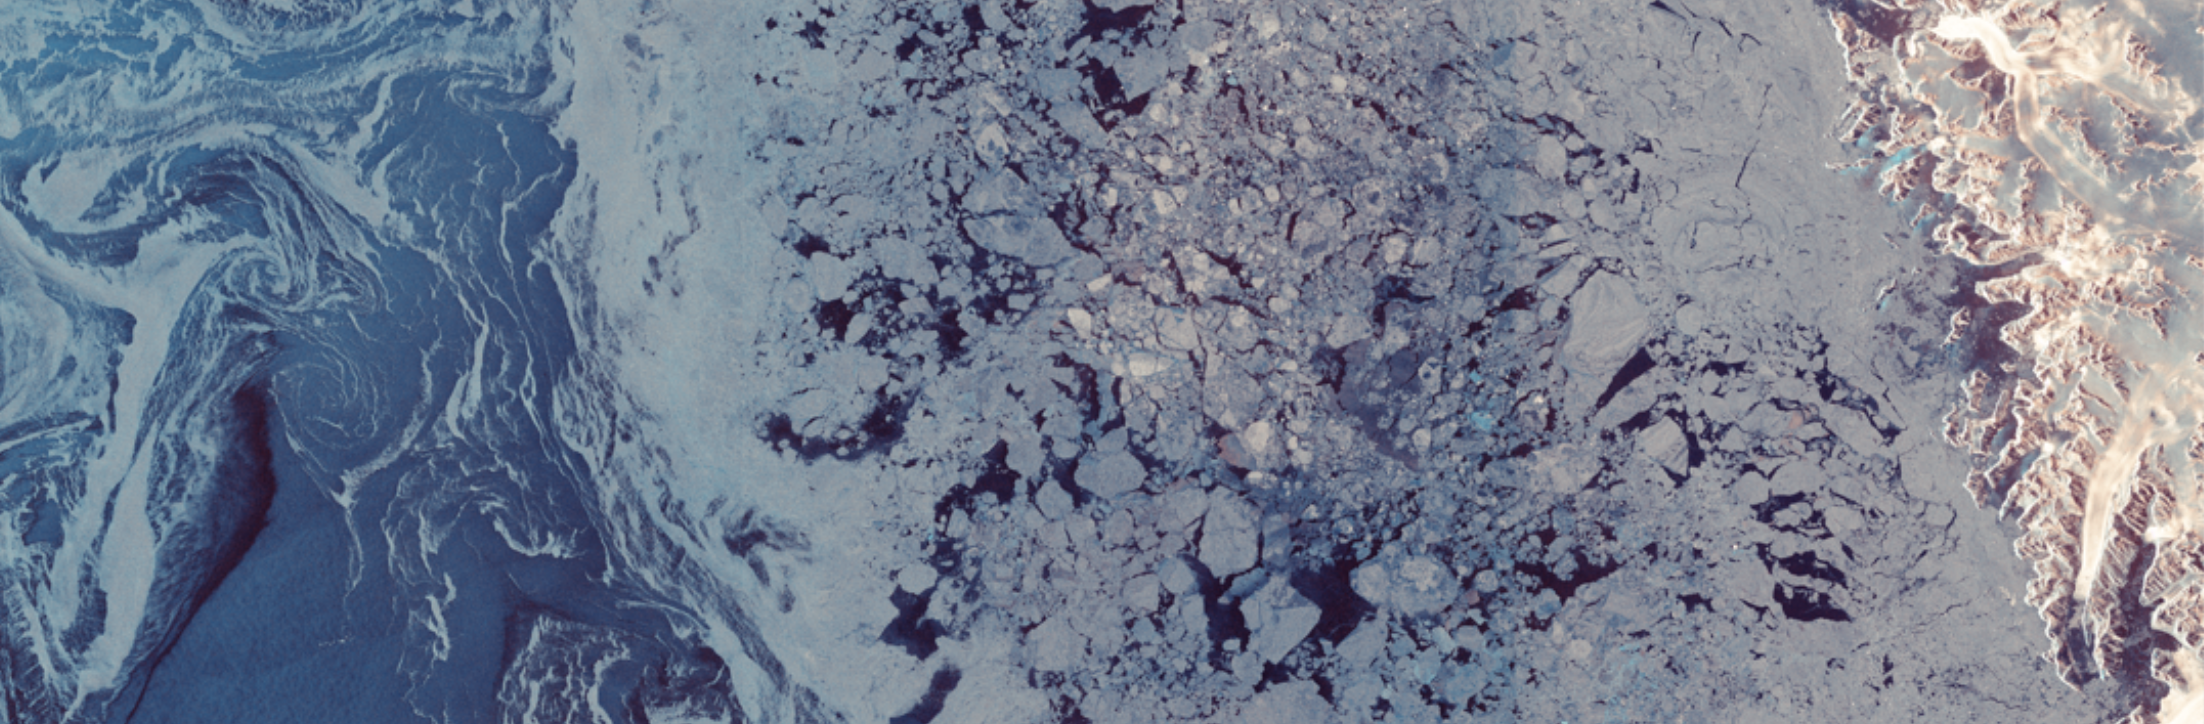

In this project, I explore how satellite altimetry data can be used to detect and calculate the sea surface height anomaly (SSHA) of ocean eddies. I display a step-by-step process to identify a known eddy using a ready-made eddy database (the Mesoscale Eddy Trajectory Atlas), find and download nearby altimetry mesaurements from Sentinel-3, and apply optimal interpolation using GPSat to reconstruct the SSHA.

## Mesoscale Eddy Trajectory Atlas

AVISO+ provides a database of mesoscale eddies created using observations of multiple satellite altimeters over the last 3 decades. I work with the META3.2 DT dataset to visualise eddy distributions and identify potentially interesting regions where optimal interpolation of altimeter-derived SLA measurements could be applied.

Key Features of META3.2 DT:
- Temporal Coverage: 1993–2022
- Spatial Resolution: Near-global coverage with detailed tracking of individual eddies.
- Eddy Parameters: Position, lifespan, rotation type (cyclonic/anticyclonic), size, and height, rotational velocity, etc.
- Applications: Ocean circulation studies, climate research, marine biology, and operational oceanography.


The META3.2 DT dataset is based on satellite altimetry observations of sea surface height (SSH) collected from multiple satellite missions over the last three decades. Absolute Dynamic Topography (ADT), which combines SSH with geoid corrections, serves as the primary input for eddy detection. A high-pass Lanczos filter (cutoff: 700 km) is applied to the ADT fields to remove large-scale ocean variability, isolating mesoscale eddies in the 100–300 km range.

Eddy boundaries are then identified using closed SSH contours from these filtered ADT maps, and they are classified as cyclonic or anticyclonic based on their rotation direction. The eddies are tracked over time by comparing their effective contours in consecutive daily altimetry-derived SSH fields, ensuring a minimum 5% overlap between detections.


Data reference: The altimetric Mesoscale Eddy Trajectory Atlas product (META3.2 DT allsat, DOI:
https://10.24400/527896/a01-2022.005.220209; (Pegliasco et al., 2022)) was produced by
SSALTO/DUACS and distributed by AVISO+ (https://www.aviso.altimetry.fr/) with support from CNES,
in collaboration with IMEDEA. This atlas was downloaded 10-03-2025, and covers the
period from January 1993 to January 2022

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import folium
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.path as mpath
from shapely.ops import transform
import pyproj
from shapely.geometry import shape
from shapely import wkt
import subprocess
import requests
import json
import shutil
import os
import zipfile
import sys
import json
import ipywidgets as widgets
from shapely.geometry import mapping
from IPython.display import display, IFrame
import matplotlib.lines as mlines

In [3]:
data_path = Path(r'C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data')

### Exploratory Data Analysis

#### The following code is used to subset the orginal eddy data from AVISO and store+save the relevant information in a geodataframe with eddy polygons defined.


In [ ]:
# Load the cyclonic eddies

# Cyclonic eddies
ds_cyclonic = xr.open_dataset(data_path / 'META3.2_DT_allsat_Cyclonic_long_19930101_20220209.nc')

# Subset the data around 2019
ds_cyclonic = ds_cyclonic.sel(obs=slice(30500000, 34100000))

# Create polygons of the eddy outlines

def create_polygons(ds, contour_lat_var, contour_lon_var):
    polygons = []
    for i in range(ds.sizes['obs']):
        if i % 50000 == 0:
            print(f'Creating polygon {i} of {ds.dims["obs"]}')
        latitudes = ds[contour_lat_var].isel(obs=i).values
        longitudes = ds[contour_lon_var].isel(obs=i).values
        polygon = Polygon(zip(longitudes, latitudes))
        polygons.append(polygon)
    return polygons

cyclonic_polygons = create_polygons(ds_cyclonic, 'effective_contour_latitude', 'effective_contour_longitude')

# Create a GeoDataFrame to store the data
cyclonic_gdf = gpd.GeoDataFrame({
    "track_number": ds_cyclonic['track'].values ,
    "time": ds_cyclonic['time'].values,
    'longitude': ds_cyclonic['longitude'].values,
    'latitude': ds_cyclonic['latitude'].values,
    "amplitude": ds_cyclonic['amplitude'].values,
    "effective_height": ds_cyclonic['effective_contour_height'].values,
    "inner_height": ds_cyclonic['inner_contour_height'].values,
    "geometry": cyclonic_polygons
}, geometry="geometry")

cyclonic_gdf = cyclonic_gdf.set_crs(epsg=4326)

# Crop the data to 2019
cyclonic_gdf = cyclonic_gdf[cyclonic_gdf['time'].dt.year == 2019]

cyclonic_gdf.to_parquet(data_path / 'cyclonic_eddies_2019.parquet')
print('Cyclonic eddies subset saved')

In [ ]:
#Load the anticyclonic eddies

#Cyclonic eddies
ds_anticyclonic = xr.open_dataset(data_path / 'META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc')

# Subset the data around 2019
ds_anticyclonic = ds_anticyclonic.sel(obs=slice(30500000, 34100000))

#Create polygons of the eddy outlines
anticyclonic_polygons = create_polygons(ds_anticyclonic, 'effective_contour_latitude', 'effective_contour_longitude')

# Create a GeoDataFrame to store the data
anticyclonic_gdf = gpd.GeoDataFrame({
    "track_number": ds_anticyclonic['track'].values ,
    "time": ds_anticyclonic['time'].values,
    'longitude': ds_anticyclonic['longitude'].values,
    'latitude': ds_anticyclonic['latitude'].values,
    "amplitude": ds_anticyclonic['amplitude'].values,
    "effective_height": ds_anticyclonic['effective_contour_height'].values,
    "inner_height": ds_anticyclonic['inner_contour_height'].values,
    "geometry": anticyclonic_polygons
}, geometry="geometry")

anticyclonic_gdf = anticyclonic_gdf.set_crs(epsg=4326)

# Crop the data to 2019
anticyclonic_gdf = anticyclonic_gdf[anticyclonic_gdf['time'].dt.year == 2019]

anticyclonic_gdf.to_parquet(data_path / 'anticyclonic_eddies_2019.parquet')
print('Anticyclonic eddies subset saved')

### Load the geodataframes containing the eddy subsets

In [4]:
anticyclonic_gdf = gpd.read_parquet(data_path / 'anticyclonic_eddies_2019.parquet')
anticyclonic_gdf.head()

track_number       time   longitude   latitude  amplitude  \
0        708928 2019-01-01  151.964188  51.163441     0.0226   
1        708928 2019-01-02  151.962189  51.155045     0.0223   
2        708928 2019-01-03  151.949387  51.167412     0.0217   
3        708928 2019-01-04  152.008545  51.156200     0.0224   
4        708928 2019-01-05  152.002136  51.166542     0.0211   

   effective_height  inner_height  \
0      2.000000e-03         0.024   
1      2.000000e-03         0.024   
2      2.000000e-03         0.022   
3      7.771561e-16         0.022   
4      7.771561e-16         0.020   

                                            geometry  
0  POLYGON ((151.88 50.84, 152.12 50.81, 152.38 5...  
1  POLYGON ((152.12 50.84, 152.38 50.87, 152.44 5...  
2  POLYGON ((152.12 50.86, 152.27 50.88, 152.38 5...  
3  POLYGON ((152.38 50.85, 152.49 50.88, 152.42 5...  
4  POLYGON ((152.38 50.87, 152.4 50.88, 152.41 51...

In [5]:
cyclonic_gdf = gpd.read_parquet(data_path / 'cyclonic_eddies_2019.parquet')
cyclonic_gdf.head()

track_number       time  longitude   latitude  amplitude  effective_height  \
0        713905 2019-01-01  99.719543 -40.455067     0.2246      7.771561e-16   
1        713905 2019-01-02  99.691483 -40.453773     0.2298      2.000000e-03   
2        713905 2019-01-03  99.656265 -40.448448     0.2341      2.000000e-03   
3        713905 2019-01-04  99.623764 -40.443928     0.2375      4.000000e-03   
4        713905 2019-01-05  99.594589 -40.442413     0.2379      4.000000e-03   

   inner_height                                           geometry  
0        -0.224  POLYGON ((98.82 -41.12, 98.65 -40.88, 98.54 -4...  
1        -0.226  POLYGON ((98.88 -41.2, 98.74 -41.12, 98.5 -40....  
2        -0.232  POLYGON ((98.7 -41.12, 98.62 -40.87, 98.5 -40....  
3        -0.232  POLYGON ((98.64 -41.12, 98.58 -40.88, 98.47 -4...  
4        -0.232  POLYGON ((98.66 -41.12, 98.47 -40.62, 98.49 -4...

#### Looking at the eddies for a single day of interest

C:\Users\dweis\AppData\Local\Temp\ipykernel_29872\231756536.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


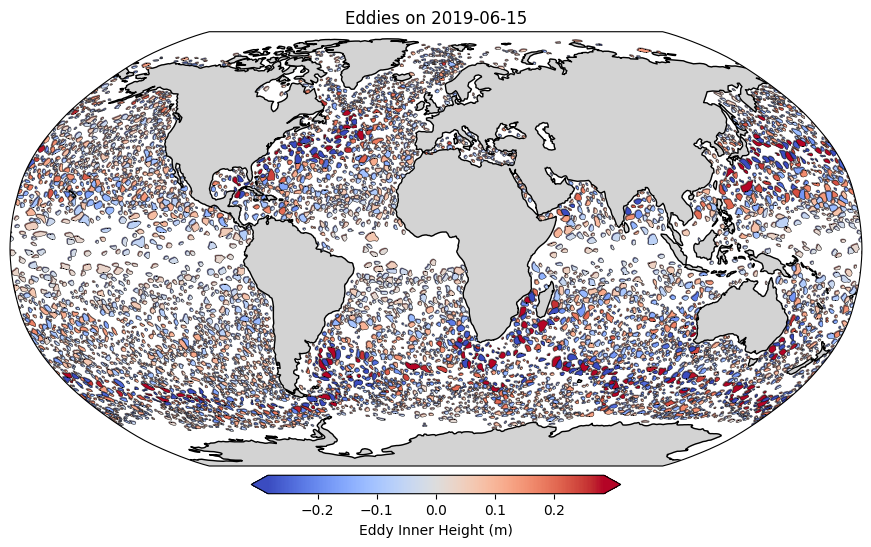

In [6]:
selected_time = "2019-06-15"
selected_time = pd.to_datetime(selected_time)

# Filter eddies for the selected time
date_anticyclonic = anticyclonic_gdf[anticyclonic_gdf["time"] == selected_time]
date_cyclonic = cyclonic_gdf[cyclonic_gdf["time"] == selected_time]

# Plot the eddies on a global map
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')


min_mins = min(date_anticyclonic["inner_height"].min(), date_cyclonic["inner_height"].min())
max_maxs = max(date_anticyclonic["inner_height"].max(), date_cyclonic["inner_height"].max())
quartile_mins = min(np.quantile(date_anticyclonic["inner_height"], 0.05), np.quantile(date_cyclonic["inner_height"], 0.05))
quartile_maxs = max(np.quantile(date_anticyclonic["inner_height"], 0.95), np.quantile(date_cyclonic["inner_height"], 0.95))
cmap_bound = max(abs(quartile_mins), abs(quartile_maxs))

norm = mcolors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
cmap = cm.get_cmap('coolwarm')

for _, row in date_anticyclonic.iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

for _, row in date_cyclonic.iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

if min_mins < - cmap_bound and max_maxs > cmap_bound:
    extend = "both"
elif min_mins < - cmap_bound:
    extend = "min"
elif max_maxs > cmap_bound:
    extend = "max"
else:
    extend = "neither"

cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.04, pad=0.02, extend=extend)
cbar.set_label("Eddy Inner Height (m)")

# Plot eddy polygons
date_anticyclonic.plot(ax=ax, facecolor="red", edgecolor="black", alpha=0.5, transform=ccrs.PlateCarree())
date_cyclonic.plot(ax=ax, facecolor="blue", edgecolor="black", alpha=0.5, transform=ccrs.PlateCarree())

# Titles and labels
plt.title(f"Eddies on {selected_time.date()}")
plt.show()


#### Crop the dataframe to include only eddies north of 60 N to focus on the Arctic region

In [7]:
arctic_cyclonic_gdf = cyclonic_gdf.cx[0:360, 60:90].copy()
arctic_anticyclonic_gdf = anticyclonic_gdf.cx[0:360, 60:90].copy()

In [8]:
arctic_anticyclonic_gdf.head()

track_number       time   longitude   latitude  amplitude  \
5504        710250 2019-01-01  345.219666  61.521732     0.0426   
5505        710250 2019-01-02  345.249420  61.527199     0.0381   
5506        710250 2019-01-03  345.279572  61.535881     0.0350   
5507        710250 2019-01-04  345.287109  61.557972     0.0330   
5508        710250 2019-01-05  345.326294  61.552456     0.0345   

      effective_height  inner_height  \
5504             0.008         0.050   
5505             0.008         0.046   
5506             0.010         0.044   
5507             0.014         0.046   
5508             0.014         0.048   

                                               geometry  
5504  POLYGON ((345.62 60.81, 345.88 60.79, 346.04 6...  
5505  POLYGON ((345.62 60.83, 345.88 60.8, 346.1 60....  
5506  POLYGON ((345.62 60.84, 345.88 60.83, 345.97 6...  
5507  POLYGON ((345.88 60.86, 345.91 60.88, 345.8 61...  
5508  POLYGON ((345.12 61.09, 345.38 60.97, 345.62 6...

C:\Users\dweis\AppData\Local\Temp\ipykernel_29872\2651350413.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


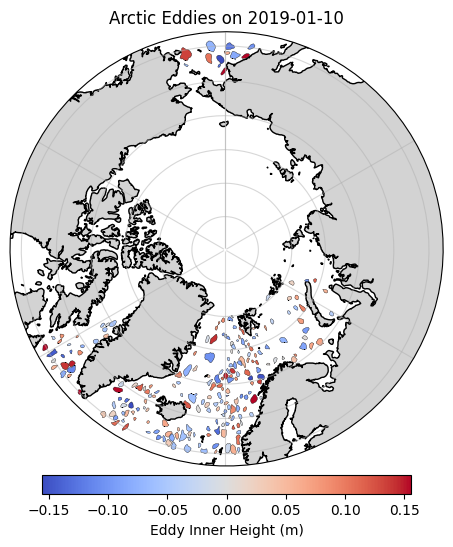

In [9]:
selected_time = "2019-01-10"

# Plot the eddies on a global map for a single day
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())

# Add features
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)


min_mins = min(arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time"] == selected_time]["inner_height"].min(), arctic_cyclonic_gdf[arctic_cyclonic_gdf["time"] == selected_time]["inner_height"].min())
max_maxs = max(arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time"] == selected_time]["inner_height"].max(), arctic_cyclonic_gdf[arctic_cyclonic_gdf["time"] == selected_time]["inner_height"].max())
quartile_mins = min(np.quantile(arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time"] == selected_time]["inner_height"], 0.05), np.quantile(arctic_cyclonic_gdf[arctic_cyclonic_gdf["time"] == selected_time]["inner_height"], 0.05))
quartile_maxs = max(np.quantile(arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time"] == selected_time]["inner_height"], 0.95), np.quantile(arctic_cyclonic_gdf[arctic_cyclonic_gdf["time"] == selected_time]["inner_height"], 0.95))
cmap_bound = max(abs(quartile_mins), abs(quartile_maxs))

norm = mcolors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
cmap = cm.get_cmap('coolwarm')

for _, row in arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time"] == selected_time].iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

for _, row in arctic_cyclonic_gdf[arctic_cyclonic_gdf["time"] == selected_time].iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.04, pad=0.02)
cbar.set_label("Eddy Inner Height (m)")


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.title(f"Arctic Eddies on {selected_time}")
plt.savefig(r"C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Figures\arctic_eddies", dpi=300, bbox_inches='tight')
plt.show()


## Eddy Selection

Below I show two options to select an ocean eddy, either manually or interactively

### Option 1: Manual Filtering

To manually find an eddy, you do some simple filtering of the dataframe(s).

In [ ]:
# Find the area of the eddies inside the 'effective contour' 
arctic_anticyclonic_gdf["effective_area"]  = arctic_anticyclonic_gdf["geometry"].to_crs("EPSG:6931").area


start_date = pd.to_datetime("2019-01-15")
end_date = pd.to_datetime("2019-01-25")

arctic_anticyclonic_gdf_filtered = arctic_anticyclonic_gdf[(arctic_anticyclonic_gdf["time"] >= start_date) & (arctic_anticyclonic_gdf["time"] <= end_date)]

# Find the 'big' eddies 
biggest_areas = arctic_anticyclonic_gdf_filtered.loc[arctic_anticyclonic_gdf_filtered.groupby('track_number')['effective_area'].idxmax()].nlargest(10, "effective_area")
large_heights = arctic_anticyclonic_gdf_filtered.loc[arctic_anticyclonic_gdf_filtered.groupby('track_number')['inner_height'].idxmax()].nlargest(10, "inner_height")


%matplotlib inline

# Plot the anticyclonic eddies with the top 10 effective areas and color them by their order
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax1.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.LAND, color='lightgray')
ax1.gridlines(alpha=0.5)


norm_area = mcolors.Normalize(vmin=0, vmax=10)
cmap_area = cm.get_cmap('tab10')

for i, (_, row) in enumerate(biggest_areas.iterrows()):
    color = cmap_area(norm_area(i))
    ax1.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )


sm_area = cm.ScalarMappable(cmap=cmap_area, norm=norm_area)
sm_area.set_array([])
cbar_area = plt.colorbar(sm_area, ax=ax1, orientation="horizontal", fraction=0.04, pad=0.02)
cbar_area.set_label("Eddy Area Rank")


cbar_area.set_ticks(np.linspace(0.5, 9.5, 10))
cbar_area.set_ticklabels([f"{i+1}" for i in range(10)])

# Plot the anticyclonic eddies with the top 10 effective heights and color them by their order
ax2.set_extent([-180, 180, 58, 90], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.LAND, color='lightgray')
ax2.gridlines(alpha=0.5)


norm_height = mcolors.Normalize(vmin=0, vmax=10)
cmap_height = cm.get_cmap('tab10')

for i, (_, row) in enumerate(large_heights.iterrows()):
    color = cmap_height(norm_height(i))
    ax2.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )


sm_height = cm.ScalarMappable(cmap=cmap_height, norm=norm_height)
sm_height.set_array([])
cbar_height = plt.colorbar(sm_height, ax=ax2, orientation="horizontal", fraction=0.04, pad=0.02)
cbar_height.set_label("Eddy Height Rank")


cbar_height.set_ticks(np.linspace(0.5, 9.5, 10))
cbar_height.set_ticklabels([f"{i+1}" for i in range(10)])

plt.suptitle(f"Top 10 Arctic Anticyclonic Eddies between {start_date.date()} and {end_date.date()}")
plt.tight_layout()
plt.show()

In [11]:
biggest_areas

track_number       time   longitude   latitude  amplitude  \
209355        721220 2019-01-25  189.388809  59.629944     0.0403   
152873        719958 2019-01-19  182.091705  59.573280     0.0315   
186173        720672 2019-01-21   28.498108  73.991829     0.0417   
177726        720481 2019-01-22   35.991928  74.139183     0.0536   
99623         718441 2019-01-18  305.332520  61.162666     0.1816   
72681         717055 2019-01-19  309.060699  59.647861     0.1661   
87759         717980 2019-01-19   10.752258  67.765175     0.0617   
181313        720572 2019-01-21   41.100479  74.937454     0.0295   
101182        718498 2019-01-19  350.651062  65.880455     0.0233   
170859        720315 2019-01-19  298.268799  59.721630     0.0716   

        effective_height  inner_height  \
209355             0.026         0.066   
152873             0.040         0.070   
186173             0.016         0.056   
177726             0.014         0.066   
99623             -0.044         0.136   
72681             -0.002         0.164   
87759              0.068         0.128   
181313            -0.008         0.020   
101182            -0.010         0.012   
170859             0.132         0.202   

                                                 geometry  effective_area  
209355  POLYGON ((189.62 58.99, 190.12 58.91, 190.62 5...    2.044912e+10  
152873  POLYGON ((182.12 58.8, 182.88 58.72, 183.38 58...    1.901435e+10  
186173  POLYGON ((27.62 73.11, 28.12 73.23, 29.12 73.2...    1.614833e+10  
177726  POLYGON ((34.38 73.56, 34.88 73.49, 35.73 73.6...    1.523855e+10  
99623   POLYGON ((304.88 60.59, 305.12 60.45, 305.62 6...    1.481180e+10  
72681   POLYGON ((308.88 58.97, 309.12 58.97, 309.38 5...    1.434386e+10  
87759   POLYGON ((10.88 67.08, 11.38 67.04, 11.88 67.1...    1.366034e+10  
181313  POLYGON ((40.12 74.33, 40.62 74.23, 40.88 74.2...    1.169499e+10  
101182  POLYGON ((350.62 65.34, 351.12 65.3, 351.62 65...    1.153702e+10  
170859  POLYGON ((298.38 59.08, 298.62 59.06, 298.88 5...    1.153048e+10

In [12]:
large_heights

track_number       time   longitude   latitude  amplitude  \
170855        720315 2019-01-15  298.344696  59.793324     0.0783   
192194        720827 2019-01-24  307.399719  61.867043     0.1640   
9332          711207 2019-01-15  322.483185  63.948158     0.1084   
87571         717976 2019-01-15  174.181198  61.193462     0.0598   
72682         717055 2019-01-20  309.020447  59.651093     0.1564   
99620         718441 2019-01-15  305.565552  61.274590     0.1775   
157869        720060 2019-01-15  184.352264  63.020397     0.0304   
53688         715854 2019-01-16  327.964905  66.014557     0.0591   
87763         717980 2019-01-23   11.001556  67.548401     0.0773   
100024        718458 2019-01-23   10.566788  70.073784     0.1618   

        effective_height  inner_height  \
170855      1.420000e-01         0.220   
192194      4.600000e-02         0.210   
9332        7.200000e-02         0.180   
87571       1.220000e-01         0.180   
72682       1.400000e-02         0.170   
99620      -1.200000e-02         0.164   
157869      1.340000e-01         0.164   
53688       1.040000e-01         0.162   
87763       8.400000e-02         0.160   
100024      7.771561e-16         0.160   

                                                 geometry  effective_area  
170855  POLYGON ((298.62 59.25, 298.88 59.27, 299.09 5...    8.276140e+09  
192194  POLYGON ((306.88 61.59, 307.12 61.51, 307.38 6...    7.423182e+09  
9332    POLYGON ((321.12 63.57, 321.62 63.48, 322.12 6...    1.055388e+10  
87571   POLYGON ((173.38 60.86, 173.62 60.85, 173.88 6...    3.855151e+09  
72682   POLYGON ((309.12 59.1, 309.38 59.13, 309.62 59...    1.124555e+10  
99620   POLYGON ((305.62 60.19, 305.88 60.21, 306.38 6...    1.348825e+10  
157869  POLYGON ((183.88 62.87, 184.12 62.8, 184.38 62...    3.696855e+09  
53688   POLYGON ((327.12 65.75, 327.38 65.74, 327.62 6...    4.893223e+09  
87763   POLYGON ((10.88 67.04, 11.12 67, 11.62 66.99, ...    1.187206e+10  
100024  POLYGON ((10.88 69.52, 11.12 69.56, 11.38 69.6...    6.529116e+09

Make selection

In [13]:
#Based on the maps, I feel like exploring the eddy ranked 5th by effective area
selected_eddy = arctic_anticyclonic_gdf_filtered.loc[biggest_areas.index[5-1]]
selected_eddy

track_number                                                   718441
time                                              2019-01-18 00:00:00
longitude                                                   305.33252
latitude                                                    61.162666
amplitude                                                      0.1816
effective_height                                               -0.044
inner_height                                                    0.136
geometry            POLYGON ((304.88 60.59, 305.12 60.45, 305.62 6...
effective_area                                     14811804544.732445
Name: 99623, dtype: object

### Option 2: Interactive Selection

As a more interactive selection you can move around the figure and click on some different eddies to see their properties. I will use this viewer to obtain the same eddy as in the previous step.

In [17]:
arctic_cyclonic_gdf["time"] = pd.to_datetime(arctic_cyclonic_gdf["time"])
arctic_anticyclonic_gdf["time"] = pd.to_datetime(arctic_anticyclonic_gdf["time"])

arctic_cyclonic_gdf["time_str"] = arctic_cyclonic_gdf["time"].dt.strftime("%Y-%m-%d")
arctic_anticyclonic_gdf["time_str"] = arctic_anticyclonic_gdf["time"].dt.strftime("%Y-%m-%d")

# Calculate Effective Area (Vectorised & Projected)
cyclonic_proj = arctic_cyclonic_gdf.to_crs("EPSG:6931")
anticyclonic_proj = arctic_anticyclonic_gdf.to_crs("EPSG:6931")

arctic_cyclonic_gdf["effective_area"] = cyclonic_proj.area / 1e6
arctic_anticyclonic_gdf["effective_area"] = anticyclonic_proj.area / 1e6

# Calculate Centroids (Vectorised)
cyclonic_centroids = cyclonic_proj.centroid.to_crs("EPSG:4326")
anticyclonic_centroids = anticyclonic_proj.centroid.to_crs("EPSG:4326")

arctic_cyclonic_gdf["lat"] = cyclonic_centroids.y
arctic_cyclonic_gdf["lon"] = cyclonic_centroids.x
arctic_anticyclonic_gdf["lat"] = anticyclonic_centroids.y
arctic_anticyclonic_gdf["lon"] = anticyclonic_centroids.x


arctic_cyclonic_gdf["type"] = "Cyclonic"
arctic_anticyclonic_gdf["type"] = "Anticyclonic"


arctic_cyclonic_gdf = arctic_cyclonic_gdf.to_crs(epsg=4326)
arctic_anticyclonic_gdf = arctic_anticyclonic_gdf.to_crs(epsg=4326)


available_dates = sorted(arctic_cyclonic_gdf["time"].dt.date.unique())



def create_folium_map(selected_date):
    date_str_prefix = selected_date.strftime("%Y-%m-%d")
    
    cyclonic_filtered = arctic_cyclonic_gdf[arctic_cyclonic_gdf["time_str"] == date_str_prefix]
    anticyclonic_filtered = arctic_anticyclonic_gdf[arctic_anticyclonic_gdf["time_str"] == date_str_prefix]
    
    plot_cyclonic = cyclonic_filtered.drop(columns=["time"])
    plot_anticyclonic = anticyclonic_filtered.drop(columns=["time"])
    
    print(f"Date: {date_str_prefix} | Cyclonic: {len(plot_cyclonic)} | Anticyclonic: {len(plot_anticyclonic)}")

    # Initialise Map
    m = folium.Map(location=[90, 0], zoom_start=3, tiles="OpenStreetMap")
    
    # Popup fields
    popup_fields = ["type", "track_number", "time_str", "lat", "lon", "effective_area", "inner_height"]
    popup_aliases = ["Type:", "Track #:", "Date:", "Lat:", "Lon:", "Area (km²):", "Height (m):"]
    
    # Add Layers
    if not plot_cyclonic.empty:
        folium.GeoJson(
            plot_cyclonic,
            name="Cyclonic Eddies",
            style_function=lambda x: {'color': 'blue', 'fillColor': 'blue', 'weight': 2, 'fillOpacity': 0.5},
            popup=folium.GeoJsonPopup(fields=popup_fields, aliases=popup_aliases),
            tooltip=folium.GeoJsonTooltip(fields=popup_fields, aliases=popup_aliases)
        ).add_to(m)

    if not plot_anticyclonic.empty:
        folium.GeoJson(
            plot_anticyclonic,
            name="Anticyclonic Eddies",
            style_function=lambda x: {'color': 'red', 'fillColor': 'red', 'weight': 2, 'fillOpacity': 0.5},
            popup=folium.GeoJsonPopup(fields=popup_fields, aliases=popup_aliases),
            tooltip=folium.GeoJsonTooltip(fields=popup_fields, aliases=popup_aliases)
        ).add_to(m)

    folium.LayerControl().add_to(m)

    html_content = m.get_root().render()
    encoded = base64.b64encode(html_content.encode('utf-8')).decode('utf-8')
    data_url = f"data:text/html;base64,{encoded}"
    
    return IFrame(data_url, width="100%", height="600")


date_slider = widgets.SelectionSlider(
    options=available_dates,
    description="Date",
    continuous_update=False, 
    orientation="horizontal",
    layout=widgets.Layout(width="800px")
)

output = widgets.Output()

def update_map(change):
    with output:
        output.clear_output(wait=True)
        display(create_folium_map(change.new))

date_slider.observe(update_map, names="value")

ui = widgets.VBox([date_slider, output])

display(ui)

with output:
    display(create_folium_map(available_dates[0]))

In [18]:
eddie_type = "Anticyclonic"
selected_date = "2019-01-18"
selected_track_number = 718441

selected_eddy = arctic_anticyclonic_gdf[(arctic_anticyclonic_gdf["time"].dt.date == pd.to_datetime(selected_date).date()) \
    & (arctic_anticyclonic_gdf["track_number"] == selected_track_number)].iloc[0]

selected_eddy


track_number                                                   718441
time                                              2019-01-18 00:00:00
longitude                                                   305.33252
latitude                                                    61.162666
amplitude                                                      0.1816
effective_height                                               -0.044
inner_height                                                    0.136
geometry            POLYGON ((304.88 60.59, 305.12 60.45, 305.62 6...
effective_area                                           14811.804545
time_str                                                   2019-01-18
lat                                                         61.171584
lon                                                         -54.86715
type                                                     Anticyclonic
Name: 99623, dtype: object

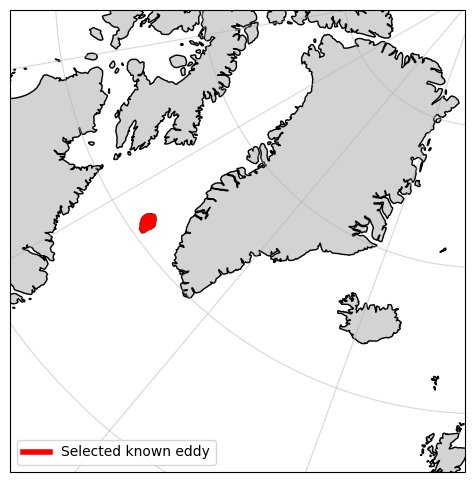

In [19]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-15, -70, 55, 85], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Plot the selected eddy
ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="red", edgecolor="black", linewidth=0.25,
)

eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, label="Selected known eddy")
ax.legend(handles=[eddy_proxy], loc='lower left')

plt.show()


In [20]:
selected_eddy_gdf = gpd.GeoDataFrame([selected_eddy])
selected_eddy_gdf.to_file(data_path / f"selected_eddy_{selected_eddy['time'].strftime('%Y-%m-%d')}_{selected_eddy['track_number']}.gpkg", layer='row', driver='GPKG')


c:\Users\dweis\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## Fetching Altimetry Data

#### Now query the Copernicus Dataspace Ecosystem (https://dataspace.copernicus.eu/) and download sentinel-3 altimery data for the selected eddy ± a number of days for optimal interpolation.

In [21]:
def get_access_token(username, password):

    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    
    # Python handles the data encoding automatically
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public"
    }
    
    response = requests.post(url, data=data)
    
    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(f"Failed to get token! Status: {response.status_code}, Response: {response.text}")
        
    access_dict = response.json()
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_new_access_token(refresh_token):

    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
    --header 'Content-Type: application/x-www-form-urlencoded' \
    --data-urlencode 'grant_type=refresh_token' \
    --data-urlencode 'refresh_token={refresh_token}' \
    --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_S3_SI_search_results_df(date):

    json = requests.get(f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-3' \
                        and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq 'SR_2_LAN_SI') \
                        and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'timeliness' and att/OData.CSC.StringAttribute/Value eq 'NT') \
                        and ContentDate/Start gt {(date-pd.Timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%SZ')} \
                        and ContentDate/End lt {(date+pd.Timedelta(days=2)).strftime('%Y-%m-%dT%H:%M:%SZ')}&$top=1000").json()

    results_df = pd.DataFrame.from_dict(json['value'])
    results_df['Satellite'] = [row['Name'][:3] for i,row in results_df.iterrows()]
    results_df['SensingStart'] = [pd.to_datetime(row['ContentDate']['Start']) for i,row in results_df.iterrows()]
    results_df['SensingEnd'] = [pd.to_datetime(row['ContentDate']['End']) for i,row in results_df.iterrows()]
    results_df = results_df[(results_df['SensingEnd'] >= date) & (results_df['SensingStart'] <= date+pd.Timedelta(days=1))]
    results_df['Cycle'] = [row['Name'][-30:-27] for i,row in results_df.iterrows()]
    results_df = results_df.sort_values(by='SensingStart')
    return results_df


#=============================================================================================================================================================#

def unzip_download(zip_path, save_loc, remove_zip_after_dl=True):

    print(f"Unpacking {zip_path.split('/')[-1]}")
    shutil.unpack_archive(zip_path, save_loc, 'zip')

    # print(f"{zip_path.split('/')[-1]} file unpacked successfully.")
    if  remove_zip_after_dl == True:
        os.remove(zip_path)

#=============================================================================================================================================================#

def is_zipfile_valid(file_path):

    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Check if the ZIP file is valid without extracting its contents
            return zip_ref.testzip() is None
    except zipfile.BadZipFile:
        return False

#=============================================================================================================================================================#


def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):

    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = (
        f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    )

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(
            f"Failed to download product {product_id}. Status Code: {response.status_code}"
        )

#=============================================================================================================================================================#

def download_S3_from_df(results_df_row, token, target_dir, rm_zip=True):

    os.makedirs(target_dir, exist_ok=True)
    zip_save_name = results_df_row['Name'][:-5]+'.zip'
    zip_path = os.path.join(target_dir,zip_save_name)

    # Check we haven't already downloaded + extracted the files
    if (os.path.exists(os.path.join(target_dir,results_df_row['Name'],'enhanced_measurement.nc')) == False) or (os.path.exists(os.path.join(target_dir,results_df_row['Name'],'standard_measurement.nc')) == False):

        print(f"Downloading {results_df_row['Name'][:-5]}")
        # Download the desired product
        downloaded_zip_valid = False
        while downloaded_zip_valid == False:
            # download_product(results_df_row['Id'], zip_path, token, )
            download_single_product(results_df_row['Id'], results_df_row['Name'][:-5], token, target_dir)
            downloaded_zip_valid = is_zipfile_valid(zip_path)
        unzip_download(zip_path, target_dir, rm_zip)




Query Copernicus Dataspace Ecosystem

In [22]:
date = selected_eddy['time']
date_window = pd.Timedelta(days=7)
dates = pd.date_range(date-date_window, date+date_window, freq='D')

#Query the Copernicus Data Space Ecosystem for Sentinel-3 sea ice thematic products for the given date range
search_results = []
for date in dates:
    print(f'Querying for {date}')
    date = date.tz_localize('UTC')
    search_results.append(get_S3_SI_search_results_df(date))

search_results_df = pd.concat(search_results)
print(f'Found {len(search_results_df)} products')

Querying for 2019-01-11 00:00:00
Querying for 2019-01-12 00:00:00
Querying for 2019-01-13 00:00:00
Querying for 2019-01-14 00:00:00
Querying for 2019-01-15 00:00:00
Querying for 2019-01-16 00:00:00
Querying for 2019-01-17 00:00:00
Querying for 2019-01-18 00:00:00
Querying for 2019-01-19 00:00:00
Querying for 2019-01-20 00:00:00
Querying for 2019-01-21 00:00:00
Querying for 2019-01-22 00:00:00
Querying for 2019-01-23 00:00:00
Querying for 2019-01-24 00:00:00
Querying for 2019-01-25 00:00:00
Found 867 products


In [23]:
search_results_df.head()

@odata.mediaContentType                                    Id  \
56  application/octet-stream  8b0c3868-e35e-37ad-b05c-ba6abb0f89f6   
57  application/octet-stream  f320f754-c605-3c0a-917f-9deadb9858c4   
58  application/octet-stream  6204cdf9-a284-3dd1-a996-378c2cc19273   
59  application/octet-stream  5cb33bb9-d4d3-3721-a9a0-384e6fdc333c   
60  application/octet-stream  d29718d6-aa15-34b0-b7c5-74be13ff2dba   

                                                 Name  \
56  S3A_SR_2_LAN_SI_20190110T234713_20190111T00075...   
57  S3B_SR_2_LAN_SI_20190110T235907_20190111T00170...   
58  S3A_SR_2_LAN_SI_20190111T003819_20190111T00570...   
59  S3B_SR_2_LAN_SI_20190111T004449_20190111T01113...   
60  S3A_SR_2_LAN_SI_20190111T012416_20190111T01515...   

                 ContentType  ContentLength                   OriginDate  \
56  application/octet-stream       44616253  2023-10-13T12:44:53.252000Z   
57  application/octet-stream       22961509  2023-10-15T16:35:34.756000Z   
58  application/octet-stream       26258203  2023-10-13T12:40:42.891000Z   
59  application/octet-stream       71281741  2023-10-15T16:07:26.083000Z   
60  application/octet-stream       48260686  2023-10-13T12:40:23.136000Z   

                PublicationDate             ModificationDate  Online  \
56  2023-10-19T06:54:14.506975Z  2023-10-26T16:55:17.961838Z    True   
57  2023-10-20T17:01:42.111405Z  2023-10-20T17:01:43.324661Z    True   
58  2023-10-19T22:08:52.519359Z  2023-10-19T22:08:54.093727Z    True   
59  2023-10-20T16:28:56.845210Z  2023-10-20T16:28:58.304268Z    True   
60  2023-10-19T06:53:09.215483Z  2023-10-26T16:54:33.415793Z    True   

                   EvictionDate  \
56  9999-12-31T23:59:59.999999Z   
57  9999-12-31T23:59:59.999999Z   
58  9999-12-31T23:59:59.999999Z   
59  9999-12-31T23:59:59.999999Z   
60  9999-12-31T23:59:59.999999Z   

                                               S3Path  \
56  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/10...   
57  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/10...   
58  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/11...   
59  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/11...   
60  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/11...   

                                             Checksum  \
56  [{'Value': '9d4f3297ddd678407ce214d0de70d2ec',...   
57  [{'Value': '5a08176b18532822cb360a223b97182d',...   
58  [{'Value': '906d8804667a62dcbcbcdb9f6e22a446',...   
59  [{'Value': '260e877c1d65ada07fc1e8d71f1b3a44',...   
60  [{'Value': '07af088a18fd4617ee0f54d033df7152',...   

                                          ContentDate  \
56  {'Start': '2019-01-10T23:47:13.325680Z', 'End'...   
57  {'Start': '2019-01-10T23:59:06.521445Z', 'End'...   
58  {'Start': '2019-01-11T00:38:19.237623Z', 'End'...   
59  {'Start': '2019-01-11T00:44:48.989028Z', 'End'...   
60  {'Start': '2019-01-11T01:24:16.083297Z', 'End'...   

                                            Footprint  \
56  geography'SRID=4326;MULTIPOLYGON (((-180 73.19...   
57  geography'SRID=4326;POLYGON ((135.02 -59.9999,...   
58  geography'SRID=4326;POLYGON ((125.867 -59.0213...   
59  geography'SRID=4326;MULTIPOLYGON (((-180 77.92...   
60  geography'SRID=4326;MULTIPOLYGON (((-180 79.49...   

                                         GeoFootprint Satellite  \
56  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3A   
57  {'type': 'Polygon', 'coordinates': [[[135.02, ...       S3B   
58  {'type': 'Polygon', 'coordinates': [[[125.867,...       S3A   
59  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3B   
60  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3A   

                       SensingStart                       SensingEnd Cycle  
56 2019-01-10 23:47:13.325680+00:00 2019-01-11 00:07:54.433557+00:00   040  
57 2019-01-10 23:59:06.521445+00:00 2019-01-11 00:17:04.390957+00:00   020  
58 2019-01-11 00:38:19.237623+00:00 2019-01-11 00:57:01.080070+00:00   040  
59 2019-01-11 00:44:48.989028+00:00 2019-01-11 01:11:36.5

To avoid downloading data that doesn't pass anywhere near our selected eddy, let us determine which of the query results interects with a defined buffer zone around the eddy

In [24]:
#Buffer the selected eddy by 500 km
buffer = 500e3

# Convert the selected eddy to a GeoDataFrame and change the CRS to EPSG:6931
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:6931", always_xy=True).transform

# Transform the selected eddy geometry to the new CRS
selected_eddy_transformed = transform(project, selected_eddy['geometry'])

# Buffer the transformed geometry
selected_eddy_buffered = selected_eddy_transformed.buffer(buffer)

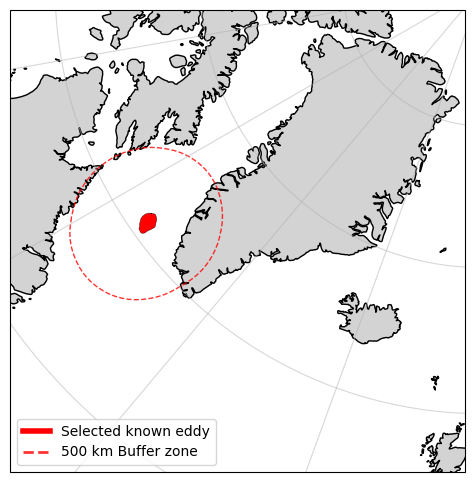

In [25]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-15, -70, 55, 85], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)


ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="red", edgecolor="black", linewidth=0.25,
)


ax.add_geometries(
    [selected_eddy_buffered], crs=ccrs.epsg(6931),
    facecolor="none", edgecolor="red", linewidth=1,
    linestyle = '--', alpha=0.8
)


eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy], loc='lower left')

plt.show()

In [26]:
# Convert the GeoFootprint column into shapely geometries
search_results_df["geometry_wkt"] = search_results_df["Footprint"].str.replace(r"geography'SRID=\d+;", "", regex=True)
search_results_df["geometry"] = search_results_df["geometry_wkt"].apply(wkt.loads)

search_results_gdf = gpd.GeoDataFrame(search_results_df, geometry='geometry', crs='EPSG:4326')

search_results_gdf = search_results_gdf.to_crs('EPSG:6931')

# Find results that intersect with the buffered eddy
intersecting_products = search_results_gdf[search_results_gdf["geometry"].intersects(selected_eddy_buffered)]

print(f'{len(intersecting_products)} products of {len(search_results_gdf)} in the date range intersect with the selected eddy')
intersecting_products.head()

53 products of 867 in the date range intersect with the selected eddy


@odata.mediaContentType                                    Id  \
59  application/octet-stream  5cb33bb9-d4d3-3721-a9a0-384e6fdc333c   
91  application/octet-stream  ba576329-e62d-351e-8c43-edf1609ced08   
92  application/octet-stream  0ea6ab2d-9005-3342-82ce-36b80ba42ff4   
57  application/octet-stream  f56b4ac0-4cf4-35a1-96a7-2f46d4157857   
58  application/octet-stream  146c0845-5770-312a-860e-de73a74c2d82   

                                                 Name  \
59  S3B_SR_2_LAN_SI_20190111T004449_20190111T01113...   
91  S3B_SR_2_LAN_SI_20190111T142139_20190111T14383...   
92  S3A_SR_2_LAN_SI_20190111T150019_20190111T15170...   
57  S3B_SR_2_LAN_SI_20190112T001925_20190112T00451...   
58  S3A_SR_2_LAN_SI_20190112T005808_20190112T01250...   

                 ContentType  ContentLength                   OriginDate  \
59  application/octet-stream       71281741  2023-10-15T16:07:26.083000Z   
91  application/octet-stream       38932641  2023-10-15T16:44:33.107000Z   
92  application/octet-stream       33443769  2023-10-13T12:37:41.200000Z   
57  application/octet-stream       67206870  2023-10-15T16:42:55.297000Z   
58  application/octet-stream       65541020  2023-10-13T12:22:38.096000Z   

                PublicationDate             ModificationDate  Online  \
59  2023-10-20T16:28:56.845210Z  2023-10-20T16:28:58.304268Z    True   
91  2023-10-20T16:34:00.153352Z  2023-10-20T16:34:01.467434Z    True   
92  2023-10-19T22:02:22.995391Z  2023-10-19T22:02:24.261230Z    True   
57  2023-10-20T16:27:42.421002Z  2023-10-20T16:27:43.997860Z    True   
58  2023-10-19T21:59:15.737721Z  2023-10-19T21:59:18.020499Z    True   

                   EvictionDate  ...  \
59  9999-12-31T23:59:59.999999Z  ...   
91  9999-12-31T23:59:59.999999Z  ...   
92  9999-12-31T23:59:59.999999Z  ...   
57  9999-12-31T23:59:59.999999Z  ...   
58  9999-12-31T23:59:59.999999Z  ...   

                                             Checksum  \
59  [{'Value': '260e877c1d65ada07fc1e8d71f1b3a44',...   
91  [{'Value': 'b5b11ecd2a0943d55092e3dcf5fa933a',...   
92  [{'Value': '6303e3c8a8531851be4e84404bf4e9af',...   
57  [{'Value': 'b97e1eab37a50a5200a9188e595c8508',...   
58  [{'Value': '9720fd77b69f5a81dda89139447e9d40',...   

                                          ContentDate  \
59  {'Start': '2019-01-11T00:44:48.989028Z', 'End'...   
91  {'Start': '2019-01-11T14:21:39.333210Z', 'End'...   
92  {'Start': '2019-01-11T15:00:19.014766Z', 'End'...   
57  {'Start': '2019-01-12T00:19:25.239984Z', 'End'...   
58  {'Start': '2019-01-12T00:58:08.366518Z', 'End'...   

                                            Footprint  \
59  geography'SRID=4326;MULTIPOLYGON (((-180 77.92...   
91  geography'SRID=4326;POLYGON ((84.0104 73.461, ...   
92  geography'SRID=4326;POLYGON ((79.1845 70.8485,...   
57  geography'SRID=4326;MULTIPOLYGON (((-180 76.41...   
58  geography'SRID=4326;MULTIPOLYGON (((-180 78.52...   

                                         GeoFootprint Satellite  \
59  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3B   
91  {'type': 'Polygon', 'coordinates': [[[84.0104,...       S3B   
92  {'type': 'Polygon', 'coordinates': [[[79.1845,...       S3A   
57  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3B   
58  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3A   

                       SensingStart                       SensingEnd Cycle  \
59 2019-01-11 00:44:48.989028+00:00 2019-01-11 01:11:36.535257+00:00   020   
91 2019-01-11 14:21:39.333210+00:00 2019-01-11 14:38:35.461506+00:00   020   
92 2019-01-11 15:00:19.014766+00:00 2019-01-11 15:16:59.936689+00:00   040   
57 2019-01-12 00:19:25.239984+00:00 2019-01-12 00:45:10.271717+00:00   020   
58 2019-01-12 00:58:08.366518+00:00 2019-01-12 01:25:03.032750+00:00   040   

                                         geometry_wkt  \
59  MULTIPOLYGON (((-180 77.92870622837371, -177.9...   
91  POLYGON ((84.0104 73.461, 80.192 74.9845, 75.5...   
92  POLYGON ((79.1845 70.8485, 76.2546

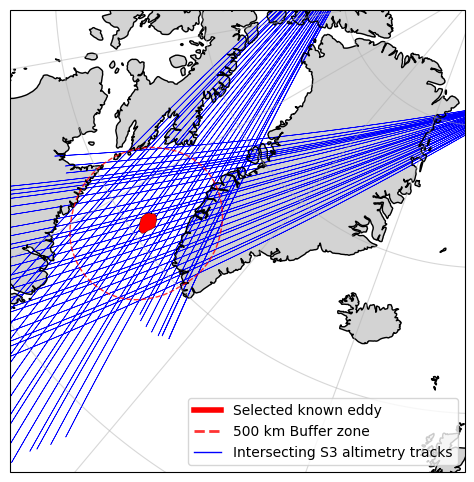

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-15, -70, 55, 85], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Plot the selected eddy
ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="red", edgecolor="black", linewidth=0.25,
)

# Plot the buffered eddy
ax.add_geometries(
    [selected_eddy_buffered], crs=ccrs.epsg(6931),
    facecolor="none", edgecolor="red", linewidth=1,
    linestyle = '--', alpha=0.8
)


intersecting_products.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=0.5, transform=ccrs.epsg(6931))

eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
s3_proxy = mlines.Line2D([], [], color='blue', linewidth=1, label="Intersecting S3 altimetry tracks")
ax.legend(handles=[eddy_proxy, buffer_proxy, s3_proxy], loc='lower right')


plt.savefig(r"C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Figures\eddy_intersection", dpi=300, bbox_inches='tight')
plt.show()

Download the relevant S3 altimetry data 

In [ ]:
target_dir = data_path / 'S3_SRAL' / f'Eddy_num_{selected_eddy["track_number"]}'
target_dir.mkdir(exist_ok=True, parents=True)

cop_dspace_usrnm = '...' # copernicus dataspace username
cop_dspace_psswrd = '...' # copernicus dataspace password

token, refresh_token = get_access_token(cop_dspace_usrnm, cop_dspace_psswrd)

for i, row in intersecting_products.iterrows():
    download_S3_from_df(row, token, target_dir)
print('Downloaded all products :)')

Downloaded: C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data\S3_SRAL\Eddy_num_718441\S3B_SR_2_LAN_SI_20190111T004449_20190111T011137_20230409T051004_1607_020_359______LN3_R_NT_005.zip
Unpacking C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data\S3_SRAL\Eddy_num_718441\S3B_SR_2_LAN_SI_20190111T004449_20190111T011137_20230409T051004_1607_020_359______LN3_R_NT_005.zip
Downloaded: C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data\S3_SRAL\Eddy_num_718441\S3B_SR_2_LAN_SI_20190111T142139_20190111T143835_20230401T103200_1016_020_367______LN3_R_NT_005.zip
Unpacking C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data\S3_SRAL\Eddy_num_718441\S3B_SR_2_LAN_SI_20190111T142139_20190111T143835_20230401T103200_1016_020_367______LN3_R_NT_005.zip
Downloaded: C:\Users\dweis\OneDrive\Documents\UCL\AI4EO\Week 8\Data\S3_SRAL\Eddy_num_718441\S3A_SR_2_LAN_SI_20190111T150019_20190111T151700_20230524T160950_1000_040_125______LN3_R_NT_005.zip
Unpacking C:\Users\dweis\OneDrive\Documents\UCL\A

: 